# Uso de modelos de Machine Learning supervisado para clasificación

Vamos a hacer uso de TF-IDF para poder vectorizar el texto y que este pueda ser usado por modelos IA no específicos para tratamiento de texto y así usar estos para la clasificación de fake news. Esta técnica transforma un texto en un vector que muestra la importancia de cada palabra en el texto, de tal manera que esta información puede ser usada por modelos de machine learning como datos para su entrenamiento. Este método tiene una desventaja y es que se pierde el contexto de las palabras ya que se pierde el orden y significado de estas quedando solo la importancia.

In [2]:
import pandas as pd
import numpy as np
import optuna
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from alibi.explainers import ALE
from alibi.explainers import plot_ale
import lime
import lime.lime_tabular
import shap

df_standarized = pd.read_csv('datos_limpios_estandarizados.csv')
df_no_standarized = pd.read_csv('datos_limpios.csv')

print("Valores nulos en 'title':", df_standarized["title"].isna().sum())
print("Valores nulos en 'text':", df_standarized["text"].isna().sum())

df_standarized[['title', 'text']] = df_standarized[['title', 'text']].fillna("")
df_no_standarized[['title', 'text']] = df_no_standarized[['title', 'text']].fillna("")

print("Valores nulos en 'title':", df_standarized["title"].isna().sum())
print("Valores nulos en 'text':", df_standarized["text"].isna().sum())

2025-05-18 22:41:21.567452: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 22:41:21.800911: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-18 22:41:22.533844: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Valores nulos en 'title': 2
Valores nulos en 'text': 0
Valores nulos en 'title': 0
Valores nulos en 'text': 0


Vamos a definir una función que muestre los resultados de las predicciones de los modelos tras el entrenamiento.

In [3]:
# Evaluación
def evaluar_prediccion(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print("Reporte de clasificación:")
    print(classification_report(y_test, y_pred))

    labels = ["Fake", "Real"]

    # Dibujar
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicción")
    plt.ylabel("Valor real")
    plt.title("Matriz de Confusión")
    plt.tight_layout()
    plt.show()

Precisión del modelo: 0.48
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.49      0.53      0.51      1825
           1       0.47      0.43      0.45      1784

    accuracy                           0.48      3609
   macro avg       0.48      0.48      0.48      3609
weighted avg       0.48      0.48      0.48      3609



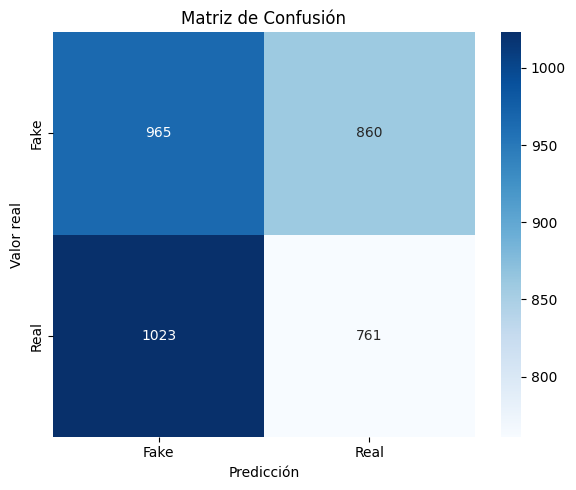

In [4]:
# Definir preprocesamiento  del texto
preprocessor = ColumnTransformer(
    transformers=[
        # Texto: TF-IDF (título y autor por separado)
        ("text", TfidfVectorizer(max_features=1000), "text"),
        ("title", TfidfVectorizer(max_features=200), "title"),
    ],
    remainder="passthrough"  # Mantener las columnas restantes sin cambios
)

# Pipeline completo: Preprocesamiento + Modelo
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier()),
])

# Entrenamiento
x = df_standarized.drop(columns=["label"])
y = df_standarized["label"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
pipeline.fit(X_train, y_train)

# Evaluación
accuracy = pipeline.score(X_test, y_test)
print(f"Precisión del modelo: {accuracy:.2f}")

# Predicción
y_pred = pipeline.predict(X_test)
evaluar_prediccion(y_test, y_pred)

Precisión del modelo: 0.51
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.50      0.59      0.54      1787
           1       0.51      0.42      0.46      1822

    accuracy                           0.51      3609
   macro avg       0.51      0.51      0.50      3609
weighted avg       0.51      0.51      0.50      3609



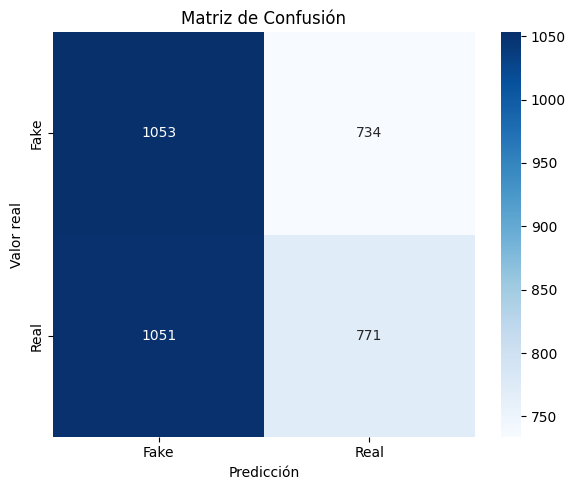

In [5]:
# Definir preprocesamiento  del texto
preprocessor = ColumnTransformer(
    transformers=[
        # Texto: TF-IDF (título y autor por separado)
        ("text", TfidfVectorizer(max_features=5000), "text"),
        ("title", TfidfVectorizer(max_features=5000), "title"),
    ],
    remainder="passthrough"  # Mantener las columnas restantes sin cambios
)

# Pipeline completo: Preprocesamiento + Modelo
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier()),
])

# Entrenamiento
x = df_no_standarized.drop(columns=["label"])
y = df_no_standarized["label"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
pipeline.fit(X_train, y_train)

# Evaluación
accuracy = pipeline.score(X_test, y_test)
print(f"Precisión del modelo: {accuracy:.2f}")

# Predicción
y_pred = pipeline.predict(X_test)
evaluar_prediccion(y_test, y_pred)

Vamos ahora a probar modelos de árboles de decisión boosteados por gradientes, los cuales se comportan bastante bien para conjuntos de datos de tipos mixtos

Precisión del modelo: 0.51
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      1819
           1       0.50      0.50      0.50      1790

    accuracy                           0.51      3609
   macro avg       0.51      0.51      0.51      3609
weighted avg       0.51      0.51      0.51      3609



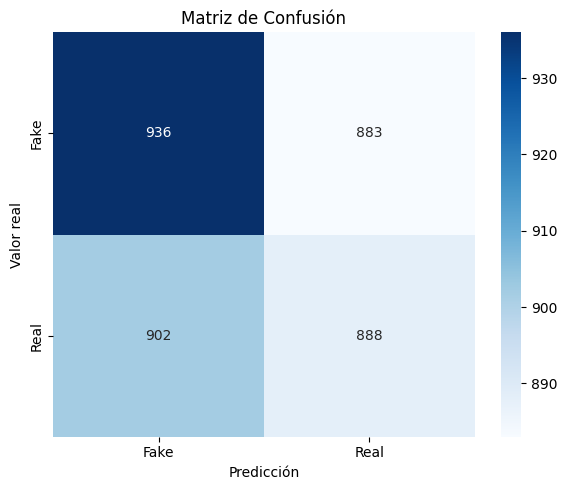

In [ ]:
# Definir preprocesamiento  del texto
preprocessor = ColumnTransformer(
    transformers=[
        # Texto: TF-IDF (título y autor por separado)
        ("text", TfidfVectorizer(max_features=1000), "text"),
        ("title", TfidfVectorizer(max_features=200), "title"),
    ],
    remainder="passthrough"  # Mantener las columnas restantes sin cambios
)

# Pipeline completo: Preprocesamiento + Modelo
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier()),
])

# Entrenamiento
x = df_standarized.drop(columns=["label"])
y = df_standarized["label"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
pipeline.fit(X_train, y_train)

# Evaluación
accuracy = pipeline.score(X_test, y_test)
print(f"Precisión del modelo: {accuracy:.2f}")

# Predicción
y_pred = pipeline.predict(X_test)
evaluar_prediccion(y_test, y_pred)

Ahora vamos a ver cuales son los campos a los que más importancia ha dado el árbol de gradientes

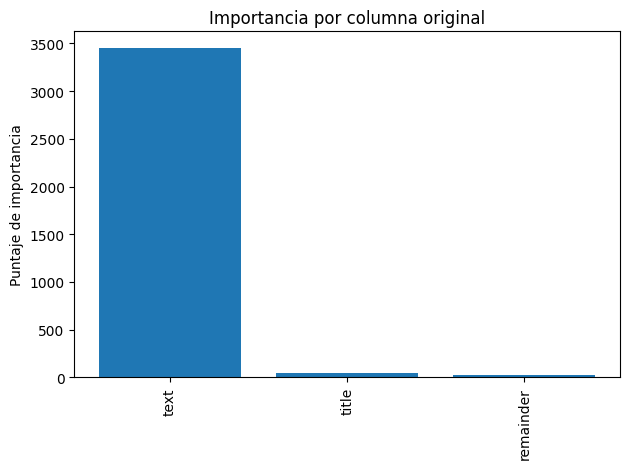

In [ ]:
column_names = df_standarized.columns.tolist()  # suponiendo que X es un DataFrame
pre = pipeline.named_steps['preprocessor']

feature_splits = {}
start = 0

for name, transformer, columns in pre.transformers_:
    if transformer == 'drop':
        continue
    elif transformer == 'passthrough':
        # `columns` puede ser 'slice(None)' si no se especifica
        if isinstance(columns, slice):
            # Determinar columnas que se pasaron por default (sin transformación)
            all_cols = X.columns.tolist()
            specified_cols = []
            for name_, trans_, cols_ in pre.transformers:
                if name_ != 'remainder':
                    if isinstance(cols_, list):
                        specified_cols.extend(cols_)
                    else:
                        specified_cols.append(cols_)
            passthrough_cols = [col for col in all_cols if col not in specified_cols]
        else:
            passthrough_cols = columns if isinstance(columns, list) else [columns]
    else:
        # Si es transformador real como TfidfVectorizer
        tf_names = transformer.get_feature_names_out()
        n_features = len(tf_names)
        # Usa el nombre del grupo (e.g., 'text', 'title')
        feature_splits[name] = (start, start + n_features)
        start += n_features

booster = pipeline.named_steps['classifier'].get_booster()
score_dict = booster.get_score(importance_type='weight')

importances = np.zeros(pipeline.named_steps['classifier'].n_features_in_)
for f, score in score_dict.items():
    idx = int(f[1:])
    importances[idx] = score

importances_by_column = {}
for col, (i_start, i_end) in feature_splits.items():
    importances_by_column[col] = np.sum(importances[i_start:i_end])

plt.bar(importances_by_column.keys(), importances_by_column.values())
plt.title("Importancia por columna original")
plt.ylabel("Puntaje de importancia")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Precisión del modelo: 0.50
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      1833
           1       0.49      0.49      0.49      1776

    accuracy                           0.50      3609
   macro avg       0.50      0.50      0.50      3609
weighted avg       0.50      0.50      0.50      3609



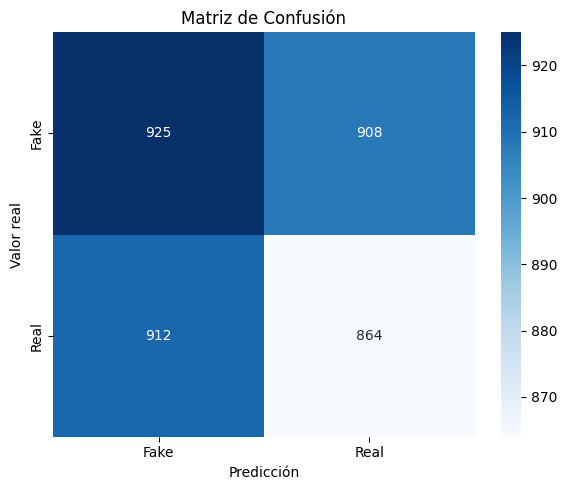

In [6]:
# Definir preprocesamiento  del texto
preprocessor = ColumnTransformer(
    transformers=[
        # Texto: TF-IDF (título y autor por separado)
        ("text", TfidfVectorizer(max_features=1000), "text"),
        ("title", TfidfVectorizer(max_features=200), "title"),
    ],
    remainder="passthrough"  # Mantener las columnas restantes sin cambios
)

# Pipeline completo: Preprocesamiento + Modelo
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier()),
])

# Entrenamiento
x = df_no_standarized.drop(columns=["label"])
y = df_no_standarized["label"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
pipeline.fit(X_train, y_train)

# Evaluación
accuracy = pipeline.score(X_test, y_test)
print(f"Precisión del modelo: {accuracy:.2f}")

# Predicción
y_pred = pipeline.predict(X_test)
evaluar_prediccion(y_test, y_pred)

Precisión del modelo: 0.49
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      1782
           1       0.51      0.50      0.51      1827

    accuracy                           0.51      3609
   macro avg       0.51      0.51      0.51      3609
weighted avg       0.51      0.51      0.51      3609



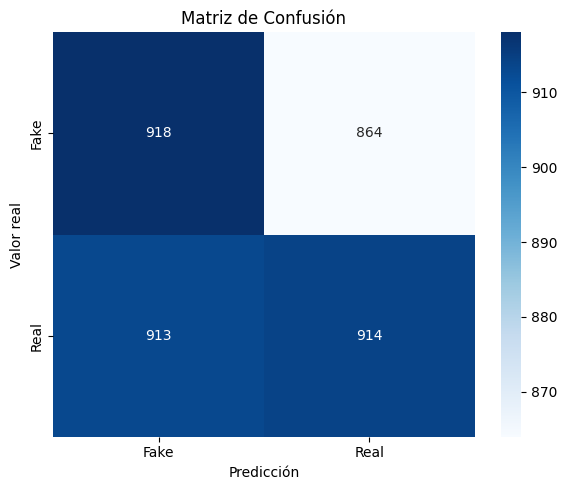

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        # Texto: TF-IDF (título y autor por separado)
        ("text", TfidfVectorizer(max_features=750), "text"),
        ("title", TfidfVectorizer(max_features=100), "title"),
    ],
    remainder="passthrough"  # Mantener las columnas restantes sin cambios
)

# Pipeline completo: Preprocesamiento + Modelo
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LinearSVC()),
])

# Entrenamiento
x = df.drop(columns=["label"])
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
pipeline.fit(X_train, y_train)

# Evaluación
# Evaluación
accuracy = pipeline.score(X_test, y_test)
print(f"Precisión del modelo: {accuracy:.2f}")

# Predicción
y_pred = pipeline.predict(X_test)
evaluar_prediccion(y_test, y_pred)

In [ ]:
df_standarized.drop(columns=["year", "month", "day"], inplace=True)

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.52      0.57      0.54      1824
           1       0.51      0.46      0.49      1785

    accuracy                           0.52      3609
   macro avg       0.52      0.52      0.51      3609
weighted avg       0.52      0.52      0.51      3609



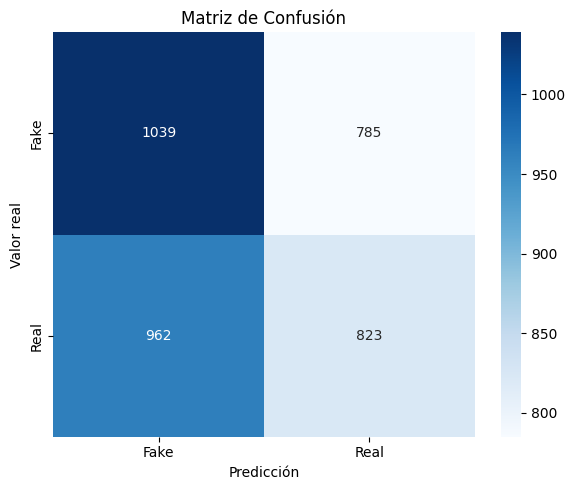

In [ ]:
# Definir preprocesamiento  del texto
preprocessor = ColumnTransformer(
    transformers=[
        # Texto: TF-IDF (título y autor por separado)
        ("text", TfidfVectorizer(max_features=1000), "text"),
        ("title", TfidfVectorizer(max_features=200), "title"),
    ],
    remainder="passthrough"  # Mantener las columnas restantes sin cambios
)

# Pipeline completo: Preprocesamiento + Modelo
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier()),
])

# Entrenamiento
x = df_standarized.drop(columns=["label"])
y = df_standarized["label"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
pipeline.fit(X_train, y_train)

# Evaluación
accuracy = pipeline.score(X_test, y_test)
print(f"Precisión del modelo: {accuracy:.2f}")

# Predicción
y_pred = pipeline.predict(X_test)
evaluar_prediccion(y_test, y_pred)

Precisión del modelo: 0.49
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.50      0.55      0.52      1829
           1       0.48      0.44      0.46      1780

    accuracy                           0.49      3609
   macro avg       0.49      0.49      0.49      3609
weighted avg       0.49      0.49      0.49      3609



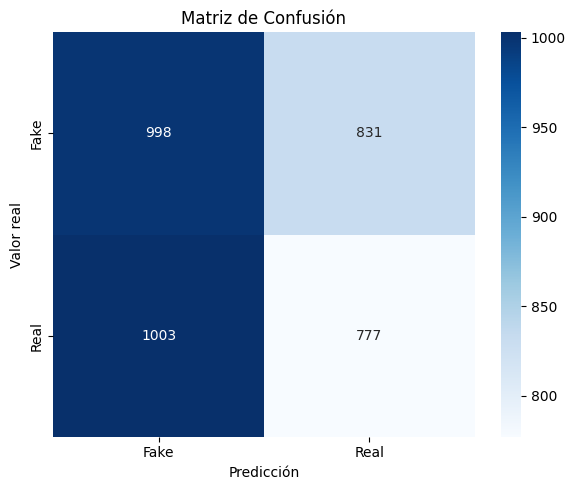

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        # Texto: TF-IDF (título y autor por separado)
        ("text", TfidfVectorizer(max_features=1000), "text"),
        ("title", TfidfVectorizer(max_features=200), "title"),
    ],
    remainder="passthrough"  # Mantener las columnas restantes sin cambios
)

# Pipeline completo: Preprocesamiento + Modelo
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LinearSVC()),
])

# Entrenamiento
x = df_standarized.drop(columns=["label"])
y = df_standarized["label"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
pipeline.fit(X_train, y_train)

# Evaluación
accuracy = pipeline.score(X_test, y_test)
print(f"Precisión del modelo: {accuracy:.2f}")

# Predicción
y_pred = pipeline.predict(X_test)
evaluar_prediccion(y_test, y_pred)

Vamos a usar optuna para poder probar varias combinaciones de parámetros para perceptrón multicapa para dar con cual de las combinaciones se comporta mejor la clasificación del dataset

In [ ]:
# Entrenamiento
x = df_standarized.drop(columns=["label"])
y = df_standarized["label"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

def objective(test):
    solver = test.suggest_categorical(
        "solver", ['adam', 'lbfgs', 'sgd'])
    activation= test.suggest_categorical(
        "activation", ['tanh', 'identity', 'logistic', 'relu'])
    first_layer_n_neurons = test.suggest_int(
        'first_layer_n_neurons', 10, 100, step=5)
    second_layer_n_neurons = test.suggest_int(
        'second_layer_n_neurons', 10, 100, step=5)
    hidden_layer_sizes = (first_layer_n_neurons, second_layer_n_neurons)
    learning_rate = test.suggest_categorical(
        'learning_rate', ['constant', 'invscaling', 'adaptive'])
    
    preprocessor = ColumnTransformer(
    transformers=[
        # Texto: TF-IDF (título y autor por separado)
        ("text", TfidfVectorizer(max_features=1000), "text"),
        ("title", TfidfVectorizer(max_features=200), "title"),
    ],
    remainder="passthrough"  # Mantener las columnas restantes sin cambios
)

    # Pipeline completo: Preprocesamiento + Modelo
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", MLPClassifier(
        learning_rate=learning_rate,
        activation=activation,
        hidden_layer_sizes=hidden_layer_sizes,
        solver=solver,
        random_state=1234,
        max_iter=100)),
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    tp = len(X_test[(y_pred == 1) &( y_test == 1)])
    fn = len(X_test[(y_test == 0 ) & (y_pred != 0)])
    fp = len(X_test[(y_pred == 1) &( y_test == 0)])

    precision = 0 if (tp + fp) == 0 else tp / (tp + fp)
    recall = 0 if (tp + fn) == 0 else tp / (tp + fn)
    neuron_combinations = first_layer_n_neurons * second_layer_n_neurons

    return precision, recall, neuron_combinations

In [ ]:
study = optuna.create_study(directions=['maximize', 'maximize', 'minimize'])
study.optimize(objective, n_trials=100)

[I 2025-05-17 17:19:30,759] A new study created in memory with name: no-name-58ad5050-8f4f-4254-9cf8-a2dc518b22d6
[I 2025-05-17 17:20:06,535] Trial 0 finished with values: [0.5005567928730512, 0.5005567928730512, 6000.0] and parameters: {'solver': 'adam', 'activation': 'identity', 'first_layer_n_neurons': 100, 'second_layer_n_neurons': 60, 'learning_rate': 'invscaling'}.
[I 2025-05-17 17:20:19,315] Trial 1 finished with values: [0.4977900552486188, 0.4977900552486188, 2450.0] and parameters: {'solver': 'adam', 'activation': 'relu', 'first_layer_n_neurons': 35, 'second_layer_n_neurons': 70, 'learning_rate': 'adaptive'}.
[I 2025-05-17 17:20:48,349] Trial 2 finished with values: [0.0, 0.0, 5225.0] and parameters: {'solver': 'sgd', 'activation': 'logistic', 'first_layer_n_neurons': 95, 'second_layer_n_neurons': 55, 'learning_rate': 'adaptive'}.
[I 2025-05-17 17:20:53,814] Trial 3 finished with values: [0.0, 0.0, 2600.0] and parameters: {'solver': 'sgd', 'activation': 'logistic', 'first_lay

RuntimeError: A single best trial cannot be retrieved from a multi-objective study. Consider using Study.best_trials to retrieve a list containing the best trials.

In [7]:
study.best_trials

[FrozenTrial(number=13, state=1, values=[0.5134408602150538, 0.5134408602150538, 700.0], datetime_start=datetime.datetime(2025, 5, 17, 17, 24, 9, 736007), datetime_complete=datetime.datetime(2025, 5, 17, 17, 24, 26, 146185), params={'solver': 'lbfgs', 'activation': 'relu', 'first_layer_n_neurons': 20, 'second_layer_n_neurons': 35, 'learning_rate': 'invscaling'}, user_attrs={}, system_attrs={'NSGAIISampler:generation': 0}, intermediate_values={}, distributions={'solver': CategoricalDistribution(choices=('adam', 'lbfgs', 'sgd')), 'activation': CategoricalDistribution(choices=('tanh', 'identity', 'logistic', 'relu')), 'first_layer_n_neurons': IntDistribution(high=100, log=False, low=10, step=5), 'second_layer_n_neurons': IntDistribution(high=100, log=False, low=10, step=5), 'learning_rate': CategoricalDistribution(choices=('constant', 'invscaling', 'adaptive'))}, trial_id=13, value=None),
 FrozenTrial(number=34, state=1, values=[0.5091093117408907, 0.5091093117408907, 250.0], datetime_sta

Tras hacer una prueba de 100 combinaciones distintas, vamos a sacar aquel perceptrón multicapa que mejores resultados ha dado para analizarlo individualmente.

/home/pelli/Master/aiiotFakeNews/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Precisión del modelo: 0.51
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.52      0.51      0.52      1859
           1       0.49      0.50      0.50      1750

    accuracy                           0.51      3609
   macro avg       0.51      0.51      0.51      3609
weighted avg       0.51      0.51      0.51      3609



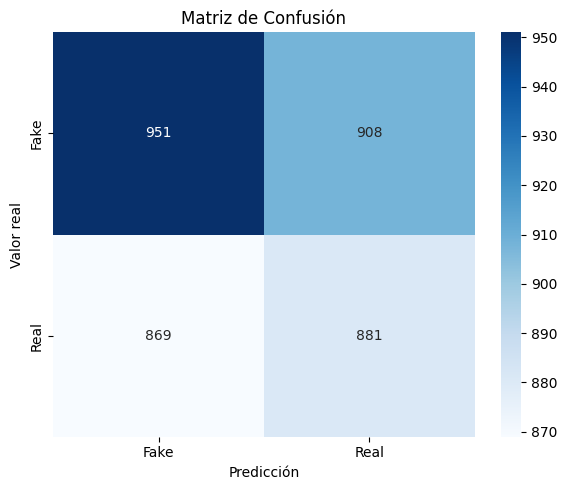

In [37]:
preprocessor = ColumnTransformer(
    transformers=[
        # Texto: TF-IDF (título y autor por separado)
        ("text", TfidfVectorizer(max_features=1000), "text"),
        ("title", TfidfVectorizer(max_features=200), "title"),
    ],
    remainder="passthrough"  # Mantener las columnas restantes sin cambios
)

# Pipeline completo: Preprocesamiento + Modelo
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", MLPClassifier(
        learning_rate='invscaling',
        activation='relu',
        hidden_layer_sizes=(20, 35),
        solver='lbfgs',
        random_state=1234,
        max_iter=100)),
])

# Entrenamiento
x = df.drop(columns=["label"])
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
pipeline.fit(X_train, y_train)

# Evaluación
accuracy = pipeline.score(X_test, y_test)
print(f"Precisión del modelo: {accuracy:.2f}")

# Predicción
y_pred = pipeline.predict(X_test)
evaluar_prediccion(y_test, y_pred)